In [4]:
# Imports
import os
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from itertools import combinations

In [5]:
# User Settings
wt_folder = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Event_Detection\Threshold_Prominence_2\WT'
ko_folder = r'Z:\UriMons\Fiber Photometry\adBNST_eEPA_GCaMP8s\Event_Detection\Threshold_Prominence_2\KO'

In [6]:
# imports (in case not already present)
import os, pandas as pd, numpy as np
from statsmodels.multivariate.manova import MANOVA

# Define dependent variables
# dep_vars = ['event_count', 'avg_peak_amp', 'total_area']
dep_vars = ['event_count', 'total_area']

# Robust loader
def load_data(folder, group):
    """
    Reads each .xlsx in `folder`, sheet 'Bin_summary'.
    Keeps the left-most columns up to the length of the known mapping,
    and renames only the number of columns actually present.
    """
    data = []
    # left-to-right expected column names from your sheets
    expected_cols = [
        'bin', 'bin_start', 'bin_end',
        'event_count', 'avg_peak_amp', 'sd_peak_amp',
        'total_area', 'sd_total_area', 'n'   # include optional SD of area and an n column if present
    ]

    for file in os.listdir(folder):
        if not file.lower().endswith('.xlsx'):
            continue

        file_path = os.path.join(folder, file)
        df = pd.read_excel(file_path, sheet_name='Bin_summary')

        # keep at most len(expected_cols) columns
        num_cols = df.shape[1]
        keep = min(num_cols, len(expected_cols))
        df = df.iloc[:, :keep].copy()

        # rename only the kept columns
        df.columns = expected_cols[:keep]

        df['group'] = group
        data.append(df)

    if not data:
        raise ValueError(f"No .xlsx files found in {folder}")
    out = pd.concat(data, ignore_index=True)

    # types
    if 'bin' in out.columns:
        out['bin'] = out['bin'].astype(str)  # categorical bins as strings for C(bin)
    for c in ['event_count', 'avg_peak_amp', 'sd_peak_amp', 'total_area', 'sd_total_area', 'n']:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce')

    return out

# Load WT and KO data
wt_data = load_data(wt_folder, 'WT')
ko_data = load_data(ko_folder, 'KO')

# Combine data from both groups
data = pd.concat([wt_data, ko_data], ignore_index=True)

# Compute per–group×bin SDs only from raw values, not from already-aggregated SD columns
# (If your Excel already contains SD columns, we won't overwrite them.)
if 'event_count' in data.columns:
    data['sd_event_count'] = data.groupby(['group', 'bin'])['event_count'].transform('std')
if 'total_area' in data.columns:
    data['sd_total_area']  = data.groupby(['group', 'bin'])['total_area'].transform('std')

# sample size per group×bin
n_per_cell = data.groupby(['group', 'bin'])['group'].transform('count')

# SEMs, computed safely only if their SD exists
if 'sd_event_count' in data.columns:
    data['sem_event_count'] = data['sd_event_count'] / np.sqrt(n_per_cell)
if 'sd_total_area' in data.columns:
    data['sem_total_area']  = data['sd_total_area']  / np.sqrt(n_per_cell)
if 'sd_peak_amp' in data.columns:
    data['sem_avg_peak_amp'] = data['sd_peak_amp']  / np.sqrt(n_per_cell)

# Build MANOVA formula using only columns that exist
present_dep_vars = [v for v in dep_vars if v in data.columns]
if not present_dep_vars:
    raise ValueError(f"None of the requested dependent vars exist in the data: {dep_vars}")

# MANOVA requires complete cases on the variables involved
manova_data = data[['group', 'bin'] + present_dep_vars].dropna().copy()

# Ensure group is categorical and bin is treated as categorical in the formula
manova_data['group'] = manova_data['group'].astype('category')
manova_data['bin']   = manova_data['bin'].astype(str)

formula = ' + '.join(present_dep_vars) + ' ~ group * C(bin)'
maov = MANOVA.from_formula(formula, data=manova_data)
print(maov.mv_test())


                  Multivariate linear model
                                                              
--------------------------------------------------------------
        Intercept        Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.5713 2.0000 109.0000 40.9022 0.0000
          Pillai's trace 0.4287 2.0000 109.0000 40.9022 0.0000
  Hotelling-Lawley trace 0.7505 2.0000 109.0000 40.9022 0.0000
     Roy's greatest root 0.7505 2.0000 109.0000 40.9022 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          group          Value  Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.9654 2.0000 109.0000  1.9530 0.1468
          Pillai's trace 0.0346 2.0000 109.0000  1.9530 0.1468
  Hotelling

The rest of code need to change - so it'll account for the event and area SD that is now calculated above

In [7]:
# Post-hoc analysis
posthoc_results = {}
for dep_var in dep_vars:
    formula = f'{dep_var} ~ group * C(bin)'
    model = sm.formula.ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    posthoc_results[dep_var] = anova_table
    print(f'ANOVA for {dep_var}:')
    print(anova_table)

p_values = [anova_table['PR(>F)'][1] for anova_table in posthoc_results.values()]
_, p_corr, _, _ = multipletests(p_values, method='bonferroni')
print('Corrected p-values (Bonferroni):', p_corr)

ANOVA for event_count:
                   sum_sq     df          F        PR(>F)
group         1825.492500    1.0  28.028345  6.175814e-07
C(bin)        1553.853846    9.0   2.650849  8.082167e-03
group:C(bin)   746.028654    9.0   1.272713  2.597807e-01
Residual      7164.325000  110.0        NaN           NaN
ANOVA for total_area:
                    sum_sq     df         F    PR(>F)
group         1.004219e+10    1.0  5.131707  0.025451
C(bin)        8.128763e+10    9.0  4.615466  0.000035
group:C(bin)  3.577722e+10    9.0  2.031410  0.042254
Residual      2.152579e+11  110.0       NaN       NaN
Corrected p-values (Bonferroni): [1.61643348e-02 6.95000012e-05]


In [8]:
# Extract the significant dependent variable from the original data
dep_var = 'total_area'  # The variable with a significant group × bin interaction

# Initialize a list to store Tukey's HSD results
tukey_results = []

# Perform pairwise comparisons within each bin
for bin_num in sorted(data['bin'].unique()):
    # Subset data for the current bin
    bin_data = data[data['bin'] == bin_num]

    # Perform Tukey's HSD for the current bin
    tukey = pairwise_tukeyhsd(endog=bin_data[dep_var], 
                              groups=bin_data['group'], 
                              alpha=0.05)
    
    # Print results for each bin
    print(f"Tukey's HSD for {dep_var} in Bin {bin_num}:")
    print(tukey)
    print("\n")
    
    # Append the summary to the list for later processing
    tukey_results.append((bin_num, tukey.summary()))

# Optionally: Combine and save results as a DataFrame
results_df = pd.concat([pd.DataFrame(tr[1], columns=['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject']) 
                        .assign(bin=tr[0]) for tr in tukey_results])

# Display the combined results
print("Combined Tukey HSD Results:")
print(results_df)

# Save the combined results to a CSV file
results_df.to_csv("tukey_hsd_total_area_by_bin.csv", index=False)


Tukey's HSD for total_area in Bin 1:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
    KO     WT -5808.0295 0.7879 -52188.0237 40571.9647  False
-------------------------------------------------------------


Tukey's HSD for total_area in Bin 10:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj    lower     upper    reject
-----------------------------------------------------------
    KO     WT 45833.6215 0.0204 8574.2118 83093.0312   True
-----------------------------------------------------------


Tukey's HSD for total_area in Bin 2:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj     lower      upper   reject
-------------------------------------------------------------
    KO     WT -14701.4873 0.1572 -36015.0126 6612.0381  False
--------------------------

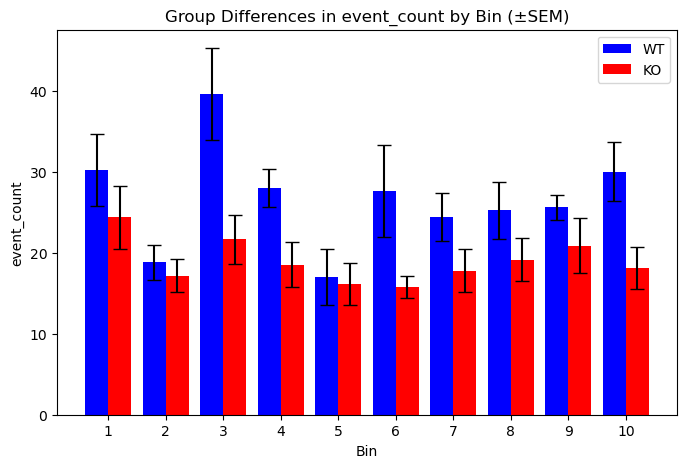

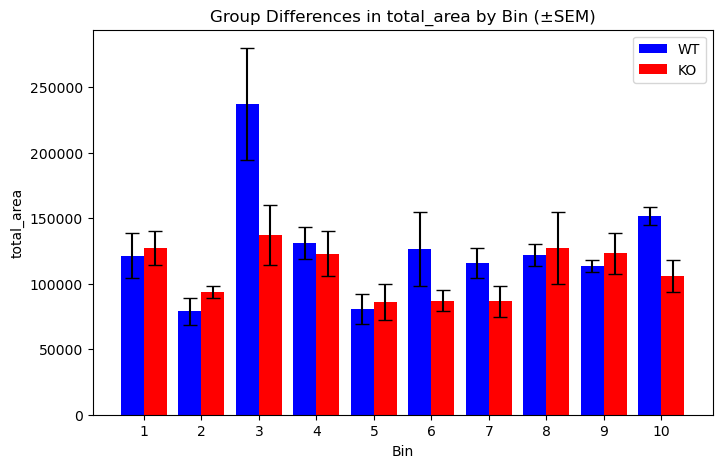

In [9]:
for dep_var in dep_vars:
    sem_var = f'sem_{dep_var}'
    # 1) build a summary table of mean ± SEM per bin×group
    summary = (
        data
        .groupby(['bin','group'])
        .agg(mean=(dep_var, 'mean'),
             sem =(sem_var,  'mean'))
        .reset_index()
    )
    # 2) pivot so WT and KO are side by side
    pivot = summary.pivot(index='bin', columns='group', values=['mean','sem'])
    pivot.index = pivot.index.astype(int)    # ensure bins are ints, not strings
    pivot = pivot.sort_index()               # sort 1,2,3,…,9,10
    bins = pivot.index.tolist()
    x = np.arange(len(bins))
    width = 0.4

    # 3) plot bars with error‐bars = SEM
    plt.figure(figsize=(8,5))
    plt.bar(x - width/2,
            pivot['mean']['WT'],
            width,
            yerr=pivot['sem']['WT'],
            capsize=5,
            color='blue',
            label='WT')
    plt.bar(x + width/2,
            pivot['mean']['KO'],
            width,
            yerr=pivot['sem']['KO'],
            capsize=5,
            color='red',
            label='KO')

    # 4) finish formatting
    plt.xticks(x, bins)
    plt.xlabel('Bin')
    plt.ylabel(dep_var)
    plt.title(f'Group Differences in {dep_var} by Bin (±SEM)')
    plt.legend()
    plt.show()


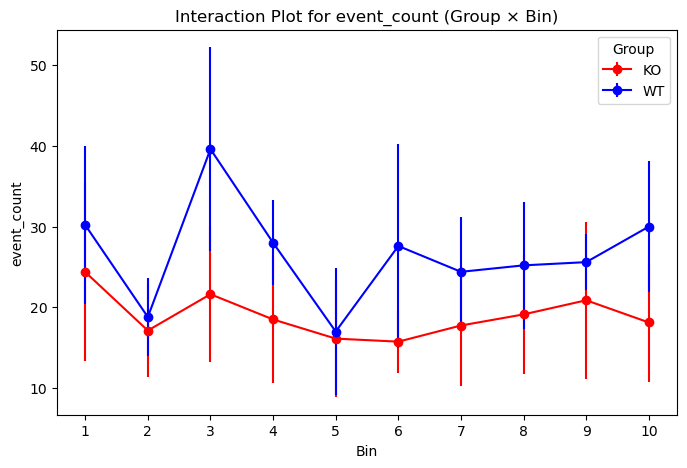

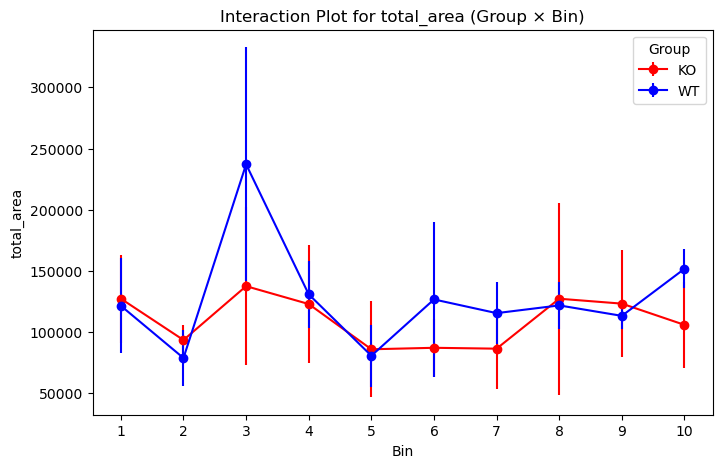

In [10]:
# Interaction plot: Showing group × bin interaction with your SDs
for dep_var, sd_var in [('event_count', 'sd_event_count'),
                        ('total_area',  'sd_total_area')]:
    plt.figure(figsize=(8, 5))

    # 1) compute group × bin means & SDs
    summary = (
        data
        .groupby(['bin','group'])
        .agg(mean=(dep_var, 'mean'),
             sd  =(sd_var,  'first'))
        .reset_index()
    )

    # 2) enforce numeric sort order on 'bin'
    summary['bin'] = summary['bin'].astype(int)
    summary = summary.sort_values('bin')

    # 3) plot each group in bin‐order with SD error bars
    for grp in sorted(summary['group'].unique()):
        grp_df = summary[summary['group'] == grp]  # already sorted by bin
        plt.errorbar(
            x=grp_df['bin'],
            y=grp_df['mean'],
            yerr=grp_df['sd'],
            marker='o', linestyle='-',
            color='blue' if grp == 'WT' else 'red',
            label=grp
        )

    bins = sorted(summary['bin'].unique())
    plt.xticks(bins)
    
    plt.title(f'Interaction Plot for {dep_var} (Group × Bin)')
    plt.xlabel('Bin')
    plt.ylabel(dep_var)
    plt.legend(title='Group')
    plt.show()